Project: /mediapipe/_project.yaml
Book: /mediapipe/_book.yaml

<link rel="stylesheet" href="/mediapipe/site.css">

# Image classification model customization guide

<table align="left" class="buttons">
  <td>
    <a href="https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/customization/image_classifier.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/colab-logo-32px_1920.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/googlesamples/mediapipe/blob/main/examples/customization/image_classifier.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/github-logo-32px_1920.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

In [ ]:
#@title License information
# Copyright 2023 The MediaPipe Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
#
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

The MediaPipe Model Maker package is a low-code solution for customizing on-device machine learning (ML) Models.

The MediaPipe image classification solution provides several models you can use immediately for machine learning (ML) in your application. However, if you need to classify images with content not covered by the provided models, you can customize any of the provided models with your own data and MediaPipe [Model Maker](https://developers.google.com/mediapipe/solutions/model_maker). This model modification tool rebuilds a portion of the model using data you provide. This method is faster than training a new model and can produce a model that is more useful for your specific application.

The following sections show you how to use Model Maker to retrain a pre-built model for image classification with your own data, which you can then use with the MediaPipe [Image Classifier](https://developers.google.com/mediapipe/solutions/vision/image_classifier). The example retrains a general purpose classification model to classify images of flowers.

This notebook shows the end-to-end process of customizing an ImageNet pretrained image classification model for recognizing flowers defined in a user customized flower dataset.

## Setup

This section describes key steps for setting up your development environment to retrain a model. These instructions describe how to update a model using [Google Colab](https://colab.research.google.com/), and you can also use Python in your own development environment. For general information on setting up your development environment for using MediaPipe, including platform version requirements, see the [Setup guide for Python](https://developers.google.com/mediapipe/solutions/setup_python).

To install the libraries for customizing a model, run the following commands:

Use the following code to import the required Python classes:

In [6]:
import os
import tensorflow as tf

from mediapipe_model_maker import image_classifier

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline




In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Prepare data

Retraining a model for image classification requires a dataset that includes all kinds of items, or *classes*, that you want the completed model to be able to identify. You can do this by trimming down a public dataset to only the classes that are relevant to your usecase, compiling your own data, or some combination of both. The dataset can be significantly smaller that what would be required to train a new model. For example, the [ImageNet](https://www.image-net.org) dataset used to train many reference models contains millions of images with thousands of categories. Transfer learning with Model Maker can retrain an existing model with a smaller dataset and still perform well, depending on your inference accuracy goals. These instructions use a smaller dataset containing 5 types of flowers, or 5 _classes_, with 600 to 800 images per class.

To download the example dataset, use the following code:

This code stores the downloaded images at the directory location saved in the `image_path` variable. That directory contains several subdirectories, each corresponding to specific class labels. Your training data should also follow this pattern: `<image_path>/<label_name>/<image_names>.*`.


### Review data

When preparing data for training with Model Maker, you should review the training data to make sure it is in the proper format, correctly classified, and organized in directories corresponding to classification labels. *This step is optional, but recommended.*

The following code block retrieves all the label names from the expected directory structure at `image_path` and prints them.

In [8]:
image_path = "/home/mihkuno/Desktop/MECDET/data/train"
print(image_path)
labels = []
for i in os.listdir(image_path):
  if os.path.isdir(os.path.join(image_path, i)):
    labels.append(i)
print(labels)

/home/mihkuno/Desktop/MECDET/data/train
['Biogesic', 'Omeprazole', 'Decolgen', 'Buscopan', 'Imodium', 'Sinecod', 'Myra_E', 'Bonamine', 'Rogin_E', 'Midol', 'Flanax', 'Lagundi', 'Tempra', 'Neurogen_E', 'Rinityn', 'Ascozin', 'Lactezin', 'Tuseran', 'Bioflu', 'DayZinc']


You can review a few of the example images from each category using the following code:

/tmp/ipykernel_10017/935167447.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))


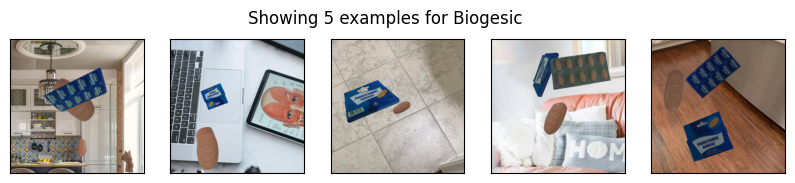

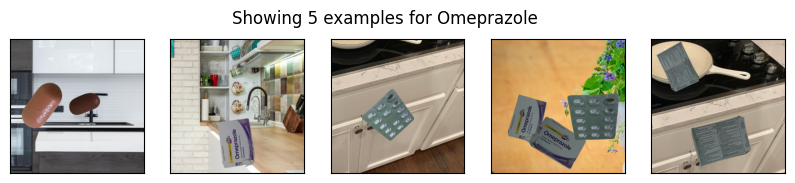

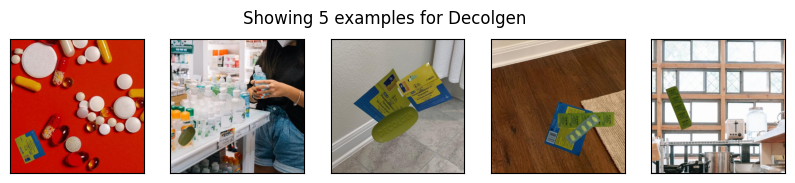

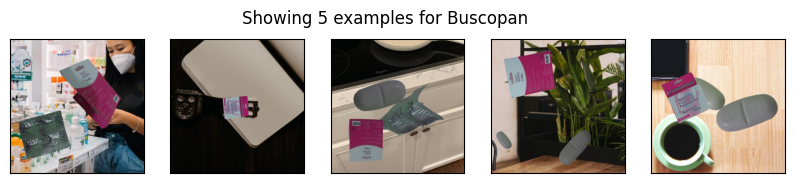

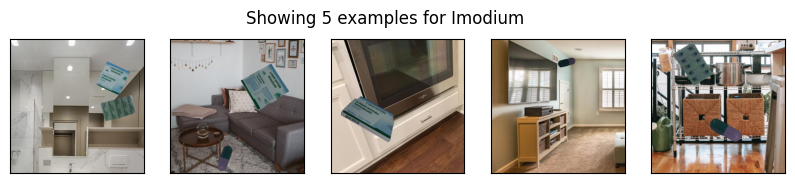

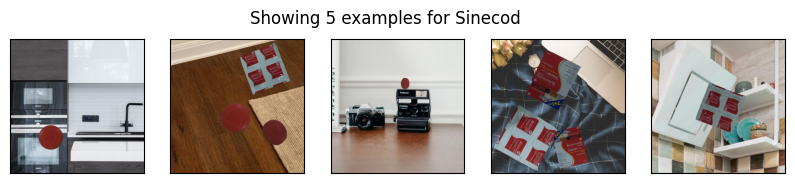

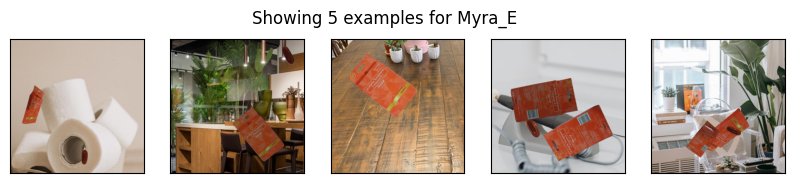

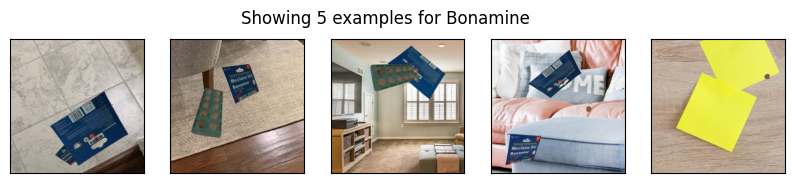

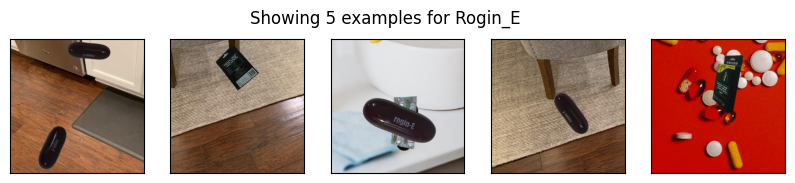

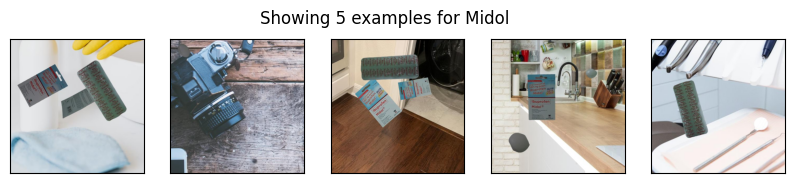

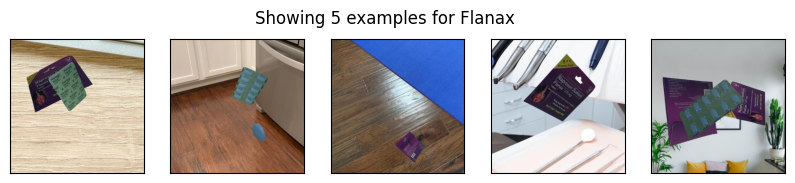

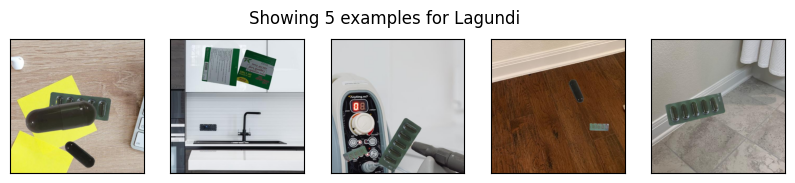

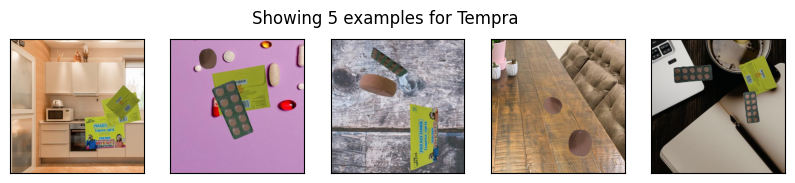

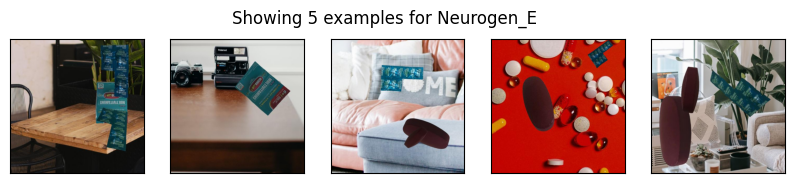

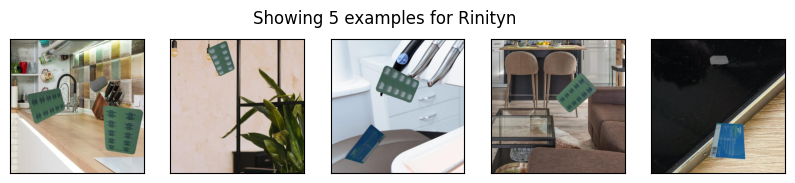

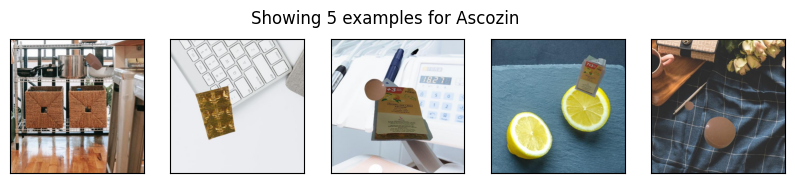

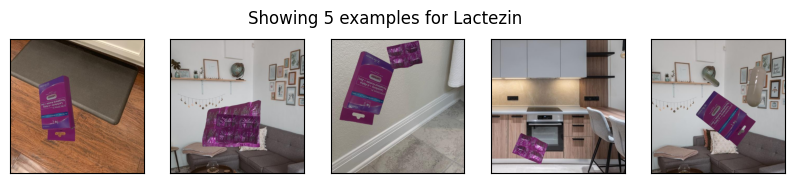

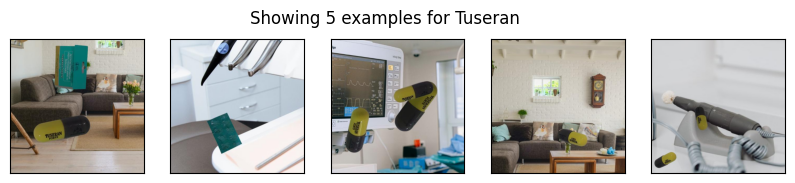

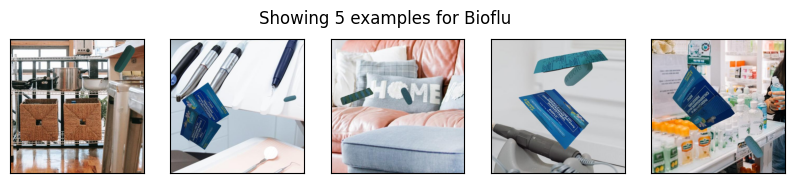

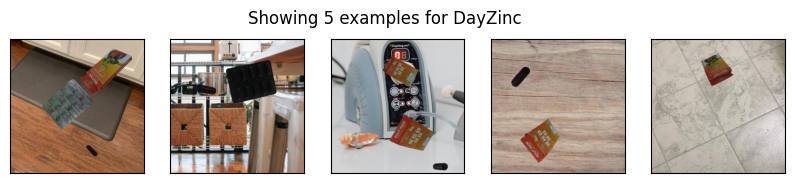

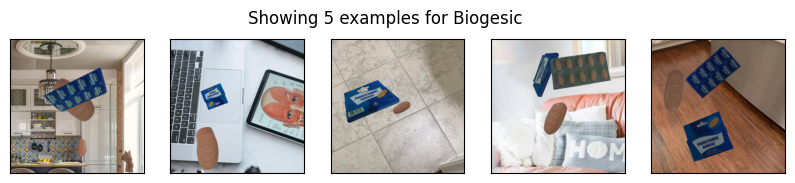

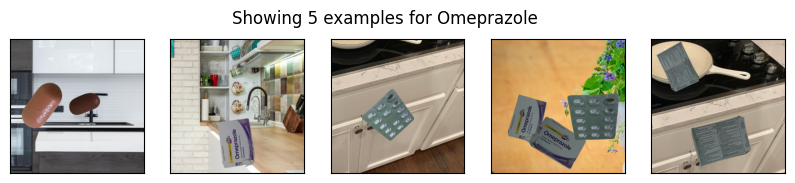

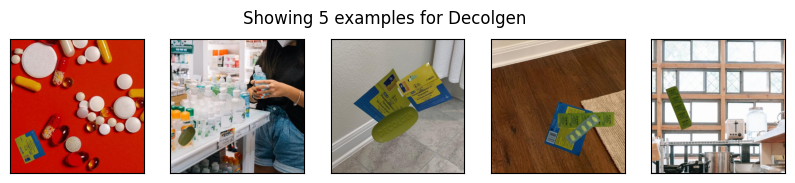

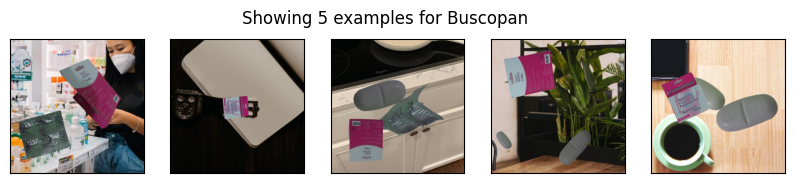

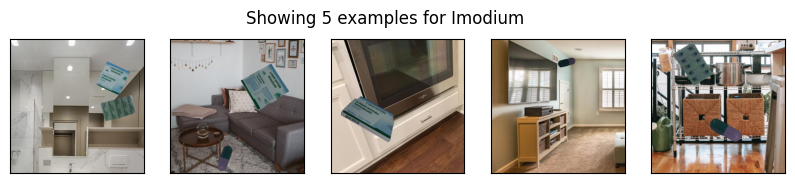

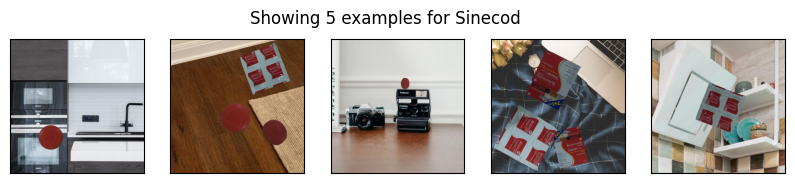

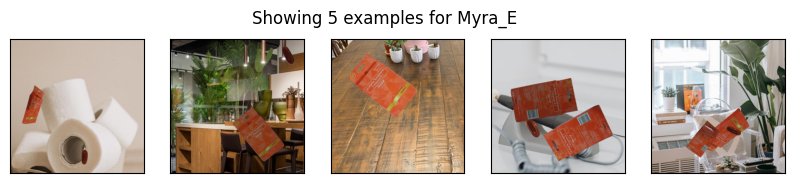

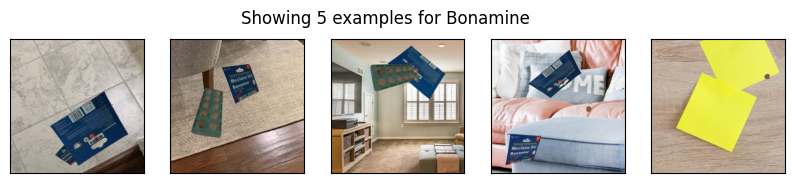

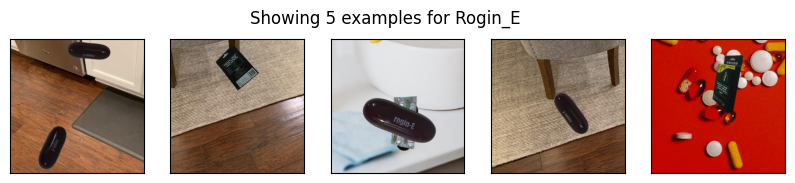

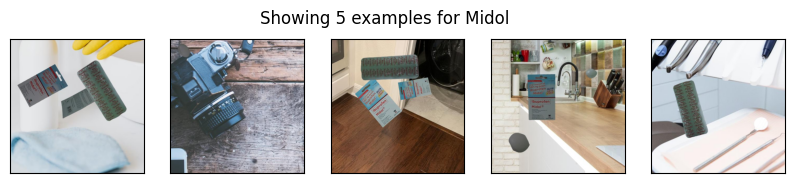

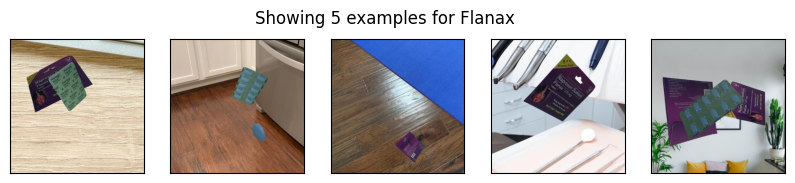

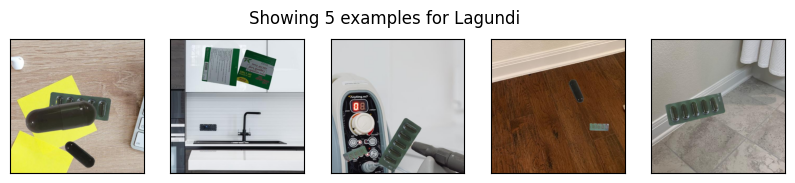

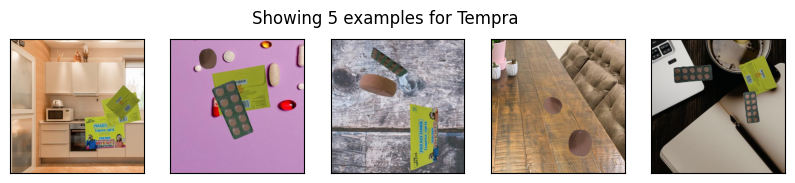

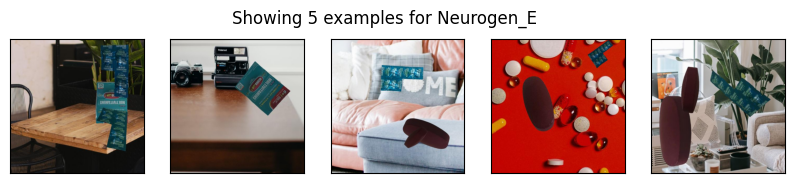

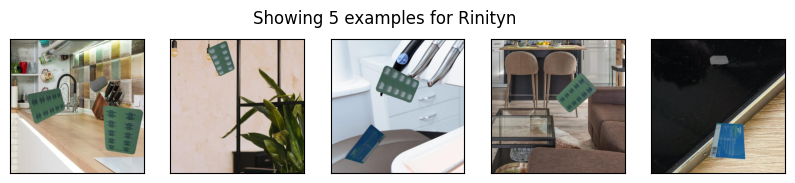

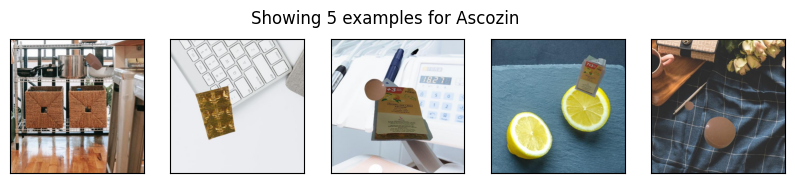

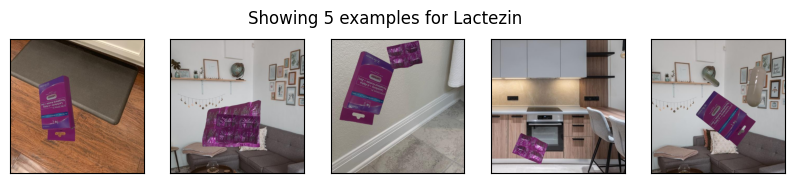

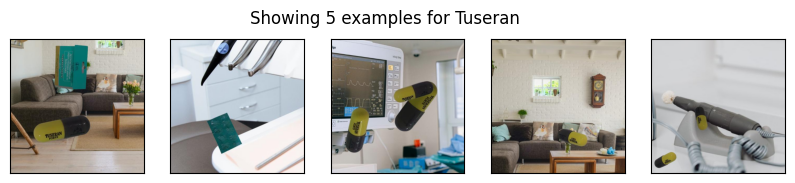

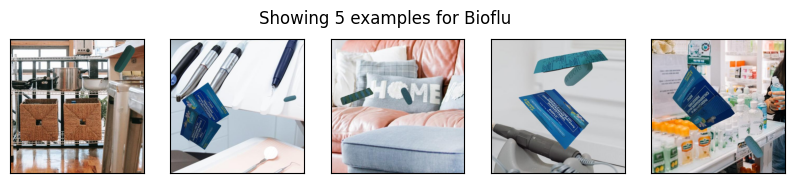

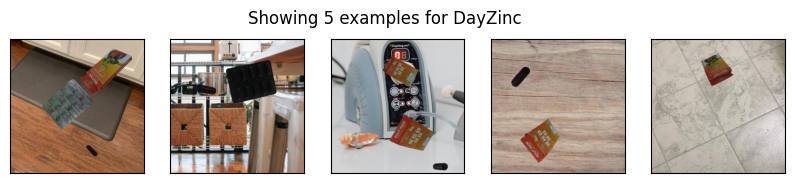

In [9]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(image_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

### Create dataset

Training data for machine learning can be large, consisting of hundreds or thousands of files which typically do not fit into available memory. You must also split it into groups for different uses: training, testing, and validation. For these reasons, Model Maker uses a `Dataset` class to organize training data and feed it to the retraining process.

To create a dataset, use the `Dataset.from_folder` method to load the data located at `image_path` and split it into training, testing, and validation groups:

In [10]:
# data = image_classifier.Dataset.from_folder(image_path)
train_data = image_classifier.Dataset.from_folder("/home/mihkuno/Desktop/MECDET/data/train")
test_data = image_classifier.Dataset.from_folder("/home/mihkuno/Desktop/MECDET/data/test")
validation_data = image_classifier.Dataset.from_folder("/home/mihkuno/Desktop/MECDET/data/val")

INFO:tensorflow:Load image with size: 40000, num_label: 20, labels: Ascozin, Bioflu, Biogesic, Bonamine, Buscopan, DayZinc, Decolgen, Flanax, Imodium, Lactezin, Lagundi, Midol, Myra_E, Neurogen_E, Omeprazole, Rinityn, Rogin_E, Sinecod, Tempra, Tuseran.
INFO:tensorflow:Load image with size: 2000, num_label: 20, labels: Ascozin, Bioflu, Biogesic, Bonamine, Buscopan, DayZinc, Decolgen, Flanax, Imodium, Lactezin, Lagundi, Midol, Myra_E, Neurogen_E, Omeprazole, Rinityn, Rogin_E, Sinecod, Tempra, Tuseran_Forte.
INFO:tensorflow:Load image with size: 9103, num_label: 20, labels: Ascozin, Bioflu, Biogesic, Bonamine, Buscopan, DayZinc, Decolgen, Flanax, Imodium, Lactezin, Lagundi, Midol, Myra_E, Neurogen_E, Omeprazole, Rinityn, Rogin_E, Sinecod, Tempra, Tuseran_Forte.


2024-05-08 19:24:53.520773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:24:53.520959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:24:53.521055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In this example, 80% of the data is used for training, with the remaining data split in half, so that 10% of the total is used for testing, and 10% for validation.

## Retrain model

Once you have completed preparing your data, you can begin retraining a model to build a new classification layer that can recognize the items types, or classes, defined by your training data. This type of model modification is called [transfer learning](https://www.wikipedia.org/wiki/Transfer_learning). The instructions below use the data prepared in the previous section to retrain an image classification model to recognize different types of flowers.

**Note:** For this type of model, the retraining process causes the model to forget any classes it was previously able to recognize. Once the retraining is complete, the new model can *only* recognize classes trained from the new dataset.

### Set retraining options

There are a few required settings to run a retraining aside from your training dataset: output directory for the model and the model architecture. Use `HParams` object `export_dir` parameter to specify a model output directory. Use the `SupportedModels` class to specify the model architecture. The image classifier solution supports the following model architectures:

- `MobileNet-V2`
- `EfficientNet-Lite0`
- `EfficientNet-Lite2`
- `EfficientNet-Lite4`

To set the required parameters, use the following code:

In [35]:
spec = image_classifier.SupportedModels.EFFICIENTNET_LITE0
hparams = image_classifier.HParams(
    export_dir="exported_model",
    batch_size=8,  # Set your desired batch size here
    epochs=15,     # Set your desired number of epochs here
    # do_fine_tuning=True
)
options = image_classifier.ImageClassifierOptions(supported_model=spec, hparams=hparams)

This example code uses MobileNetV2 model architecture, which you can learn more about from the  [MobileNetV2](https://arxiv.org/abs/1801.04381) research paper. The retraining process has many additional options, however most of them are set for you automatically. You can learn about these optional parameters in the [Retraining parameters](#retraining_parameters) section.

### Run retraining

With your training dataset and retraining options prepared, you are ready to start the retraining process. This process is resource intensive and can take a few minutes to a few hours depending on your available compute resources. Using a Google Colab environment with standard CPU processing, the example retraining below takes about 20 minutes to train on approximately 4000 images. You can typically decrease your training time by using GPU processors.

To begin the retraining process, use the `create()` method with dataset and options you previously defined:

In [36]:
model = image_classifier.ImageClassifier.create(
    train_data = train_data,
    validation_data = validation_data,
    options=options,
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer  (None, 1280)              3413024   
 )                                                               
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 20)                25620     
                                                                 
Total params: 3438644 (13.12 MB)
Trainable params: 25620 (100.08 KB)
Non-trainable params: 3413024 (13.02 MB)
_________________________________________________________________
None
INFO:tensorflow:Training the models...


INFO:tensorflow:Training the models...


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


Resuming from exported_model/checkpoint/model-0002
Epoch 1/15
5000/5000 [==============================] - 59s 12ms/step - loss: 1.9786 - accuracy: 0.5286 - val_loss: 2.3655 - val_accuracy: 0.3591
Epoch 2/15
5000/5000 [==============================] - 58s 12ms/step - loss: 1.9175 - accuracy: 0.5608 - val_loss: 2.3678 - val_accuracy: 0.3725
Epoch 3/15
5000/5000 [==============================] - 57s 11ms/step - loss: 1.9004 - accuracy: 0.5787 - val_loss: 2.3855 - val_accuracy: 0.3806
Epoch 4/15
5000/5000 [==============================] - 57s 11ms/step - loss: 1.9066 - accuracy: 0.5942 - val_loss: 2.4414 - val_accuracy: 0.3793
Epoch 5/15
5000/5000 [==============================] - 58s 12ms/step - loss: 1.9485 - accuracy: 0.5957 - val_loss: 2.4654 - val_accuracy: 0.3870
Epoch 6/15
5000/5000 [==============================] - 56s 11ms/step - loss: 1.9890 - accuracy: 0.6017 - val_loss: 2.5101 - val_accuracy: 0.3893
Epoch 7/15
5000/5000 [==============================] - 55s 11ms/step - l

### Training Evaluation

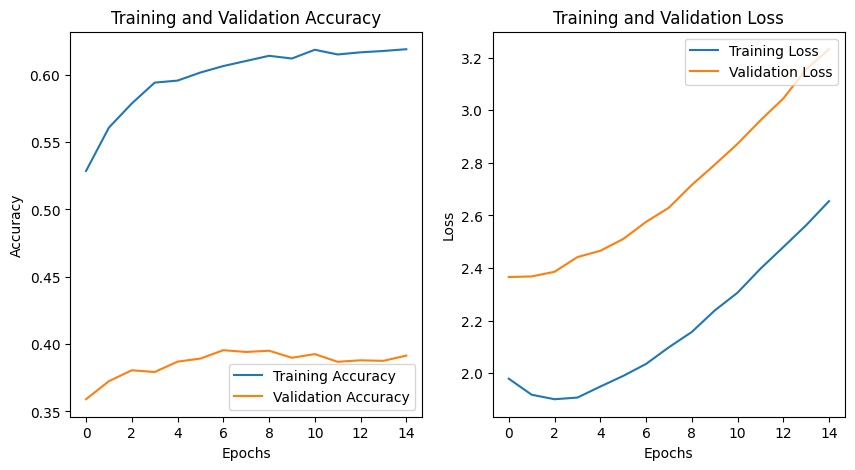

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

data = [
    [1.9786, 0.5286, 2.3655, 0.3591],
    [1.9175, 0.5608, 2.3678, 0.3725],
    [1.9004, 0.5787, 2.3855, 0.3806],
    [1.9066, 0.5942, 2.4414, 0.3793],
    [1.9485, 0.5957, 2.4654, 0.3870],
    [1.9890, 0.6017, 2.5101, 0.3893],
    [2.0346, 0.6065, 2.5753, 0.3955],
    [2.0982, 0.6103, 2.6295, 0.3942],
    [2.1563, 0.6141, 2.7160, 0.3951],
    [2.2379, 0.6121, 2.7928, 0.3899],
    [2.3059, 0.6186, 2.8725, 0.3926],
    [2.3969, 0.6151, 2.9617, 0.3869],
    [2.4794, 0.6167, 3.0449, 0.3880],
    [2.5627, 0.6177, 3.1562, 0.3876],
    [2.6544, 0.6190, 3.2327, 0.3915]
]

df = pd.DataFrame(data, columns=["loss", "accuracy", "val_loss", "val_accuracy"])

epochs_range = range(15)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, df['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, df['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, df['loss'], label='Training Loss')
plt.plot(epochs_range, df['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


### Evaluate performance

After retraining the model, you should evaluate it on a test dataset, which is typically a portion of your original dataset not used during training. Accuracy levels between 0.8 and 0.9 are generally considered very good, but your use case requirements may differ. You should also consider how fast the model can produce an inference. Higher accuracy frequently comes at the cost of longer inference times.

To run an evaluation of the example model, run it against the test portion of the dataset:

In [37]:
loss, acc = model.evaluate(test_data)
print(f'Test loss:{loss}, Test accuracy:{acc}')

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


63/63 [==============================] - 3s 39ms/step - loss: 3.2374 - accuracy: 0.3905
Test loss:3.2373502254486084, Test accuracy:0.390500009059906


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


63/63 [==============================] - 2s 36ms/step - loss: 3.2374 - accuracy: 0.3905


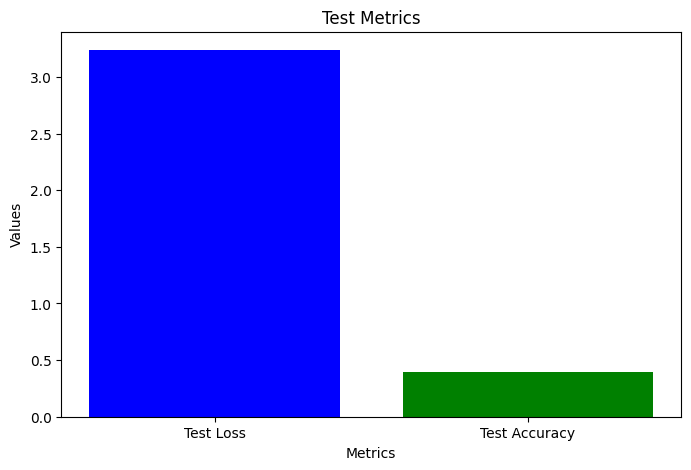

In [40]:
import matplotlib.pyplot as plt

# Assuming you have already defined and trained your model
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)

# Define the data for the bar graph
metrics = ['Test Loss', 'Test Accuracy']
values = [loss, accuracy]

# Plotting the bar graph
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics')
plt.show()


**Caution:** While high accuracy of a model is a common goal for machine learning models, you should be cautious of training to a point of [overfitting](https://en.wikipedia.org/wiki/Overfitting), which causes the model to perform extremely well with its training data, but quite poorly on new data.

         Class  Precision    Recall  F1 Score
0     Biogesic   0.413333  0.799655    0.2315
1   Omeprazole   0.539877  0.799655    0.2315
2     Decolgen   0.455782  0.799655    0.2315
3     Buscopan   0.175610  0.799655    0.2315
4      Imodium   0.292683  0.799655    0.2315
5      Sinecod   0.482270  0.799655    0.2315
6       Myra_E   0.593750  0.799655    0.2315
7     Bonamine   0.112903  0.799655    0.2315
8      Rogin_E   0.161074  0.799655    0.2315
9        Midol   0.541872  0.799655    0.2315
10      Flanax   0.453901  0.799655    0.2315
11     Lagundi   0.388571  0.799655    0.2315
12      Tempra   0.384040  0.799655    0.2315
13  Neurogen_E   0.593023  0.799655    0.2315
14     Rinityn   0.485207  0.799655    0.2315
15     Ascozin   0.227642  0.799655    0.2315
16    Lactezin   0.613333  0.799655    0.2315
17     Tuseran   0.478261  0.799655    0.2315
18      Bioflu   0.293436  0.799655    0.2315
19     DayZinc   0.377358  0.799655    0.2315


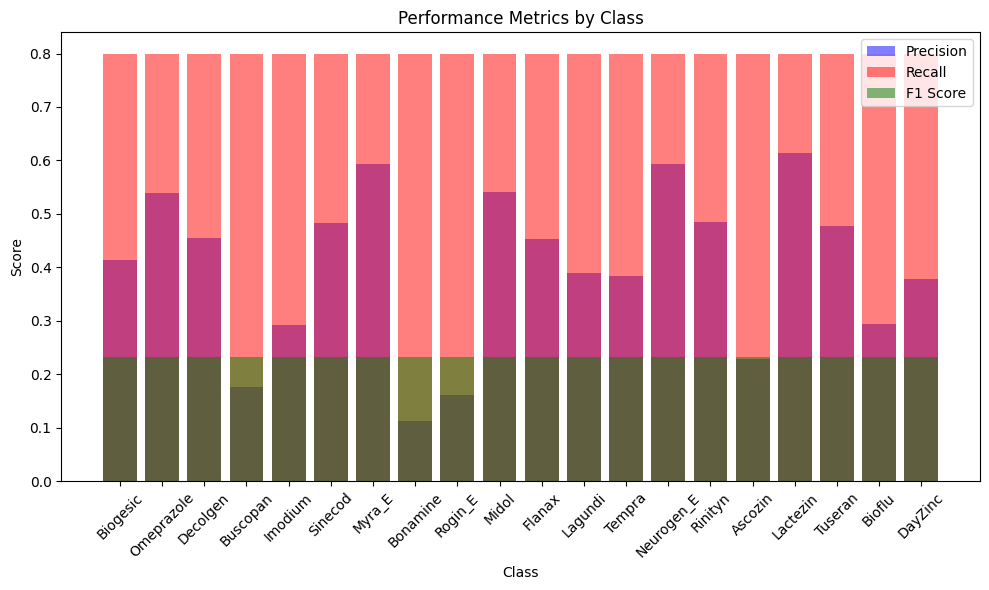

In [47]:

import pandas as pd

# Map class labels to the corresponding indices
class_labels = [labels[i] for i in range(len(metrics[2]))]

# Creating a DataFrame for the metrics
metrics_df = pd.DataFrame({
    "Class": class_labels,
    "Precision": metrics[2],
    "Recall": metrics[3],
    "F1 Score": metrics[4]
})

# Displaying the DataFrame
print(metrics_df)


# Plotting precision, recall, and F1 score
plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Class"], metrics_df["Precision"], color='b', alpha=0.5, label='Precision')
plt.bar(metrics_df["Class"], metrics_df["Recall"], color='r', alpha=0.5, label='Recall')
plt.bar(metrics_df["Class"], metrics_df["F1 Score"], color='g', alpha=0.5, label='F1 Score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Performance Metrics by Class')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Export model

After retraining a model, you must export it to Tensorflow Lite model format to use it with the MediaPipe in your application. The export process generates required model metadata, as well as a classification label file.

To export the retrained model for use in your application, use the following command:

In [48]:
model.export_model()

INFO:tensorflow:Assets written to: /tmp/tmpvll_327g/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpvll_327g/saved_model/assets
2024-05-08 21:23:58.942807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-08 21:23:58.942831: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-08 21:23:58.945503: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvll_327g/saved_model
2024-05-08 21:23:58.950643: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-08 21:23:58.950662: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvll_327g/saved_model
2024-05-08 21:23:58.964257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-08 21:23:58.969579: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-08 21:23:59.309508: I tensorflow/cc/saved_model/

INFO:tensorflow:TensorFlow Lite model exported successfully to: exported_model/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully to: exported_model/model.tflite


## Performance benchmarks

https://arxiv.org/pdf/1905.11946

Below is a summary of our benchmarking results for the supported model architectures. These models were trained and evaluated on the same flowers dataset as this notebook. When considering the model benchmarking results, there are a few important caveats to keep in mind:
- The test accuracy column reflects models which were trained with the default parameters. To optimize model performance, experiment with different model and retraining parameters in order to obtain the highest test accuracy. Refer to the [Retraining parameters](#retraining_parameters) section for more information on customizing these settings.
- The larger model architectures, such as EfficientNet_Lite4, may not acheive the highest test accuracy on simpler datasets like the flowers dataset used this notebook. Research suggests that these larger model architecture can outperform the others on more complex datasets like ImageNet, for more information, see [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf). The ImageNet dataset is more complex, with over a million training images and 1000 classes, while the flowers dataset has only 3670 training images and 5 classses.

<table>
<thead>
<tr>
<th>Model architecture</th>
<th>Test Accuracy</th>
<th>Model Size</th>
<th>CPU 1 Thread Latency(Pixel 6)</th>
<th>GPU Latency(Pixel 6)</th>
<th>EdgeTPULatency(Pixel 6)</th>
</tr>
</thead>
<tbody>
<tr>
<td>MobileNet_V2</td>
<td>85.4%</td>
<td><strong>8.9MB</strong></td>
<td>29.12</td>
<td>77.77</td>
<td>31.14</td>
</tr>
<tr>
<td>EfficientNet_Lite0</td>
<td>91.3%</td>
<td>13.5MB</td>
<td><strong>15.6</strong></td>
<td><strong>9.25</strong></td>
<td><strong>16.72</strong></td>
</tr>
<tr>
<td>EfficientNet_Lite2</td>
<td><strong>91.5%</strong></td>
<td>19.2MB</td>
<td>35.2</td>
<td>13.94</td>
<td>37.52</td>
</tr>
<tr>
<td>EfficientNet_Lite4</td>
<td>90.8%</td>
<td>46.8MB</td>
<td>103.16</td>
<td>23.14</td>
<td>114.67</td>
</tr>
</tbody>
</table>